In [1]:
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1


def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii("O'Néàl"))

O'Neal


In [2]:
def read_lines(filename):
    lines = open(filename, encoding="ISO-8859-1").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in glob.glob('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 19 ['names\\Arabic', 'names\\Chinese', 'names\\Czech', 'names\\Dutch', 'names\\English', 'names\\French', 'names\\German', 'names\\Greek', 'names\\Irish', 'names\\Italian', 'names\\Japanese', 'names\\Korean', 'names\\Polish', 'names\\Portuguese', 'names\\Russian', 'names\\Scottish', 'names\\Spanish', 'names\\Turkish', 'names\\Vietnamese']


In [71]:
import torch
import torch.nn as nn 
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
        

In [72]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

In [73]:
def make_category_input(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return Variable(tensor)

def make_chars_input(chars):
    tensor = torch.zeros(len(chars), n_letters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci][all_letters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor)

def make_target(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    tensor = torch.LongTensor(letter_indexes)
    return Variable(tensor)

In [74]:
def random_training_set():
    category, line = random_training_pair()
    category_input = make_category_input(category)
    line_input = make_chars_input(line)
    line_target = make_target(line)
    return category_input, line_input, line_target

In [75]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
        
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0] / input_line_tensor.size()[0]

In [76]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [87]:
n_epochs = 500000
print_every = 5000
plot_every = 500
all_losses = []
loss_avg = 0
learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(1, n_epochs + 1):
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
    
    if epoch % print_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

0m 43s (5000 1%) 1.9869
1m 31s (10000 2%) 2.2540
2m 16s (15000 3%) 1.8076
2m 59s (20000 4%) 2.3955
3m 41s (25000 5%) 3.6487
4m 25s (30000 6%) 2.1669
5m 9s (35000 7%) 0.9893
5m 53s (40000 8%) 1.9935
6m 38s (45000 9%) 1.7410
7m 21s (50000 10%) 1.2334
8m 5s (55000 11%) 2.9404
8m 48s (60000 12%) 1.7917
9m 30s (65000 13%) 2.5730
10m 12s (70000 14%) 2.4150
10m 54s (75000 15%) 2.3844
11m 36s (80000 16%) 1.7638
12m 18s (85000 17%) 3.0266
13m 1s (90000 18%) 2.9169
13m 43s (95000 19%) 2.0863
14m 25s (100000 20%) 2.2351
15m 7s (105000 21%) 1.2831
15m 50s (110000 22%) 1.6042
16m 32s (115000 23%) 2.0175
17m 14s (120000 24%) 2.1275
17m 56s (125000 25%) 2.1885
18m 39s (130000 26%) 2.5547
19m 21s (135000 27%) 1.5987
20m 4s (140000 28%) 1.8190
20m 46s (145000 28%) 2.0183
21m 28s (150000 30%) 1.7880
22m 12s (155000 31%) 2.6106
22m 54s (160000 32%) 2.2161
23m 37s (165000 33%) 1.9728
24m 19s (170000 34%) 2.0387
25m 2s (175000 35%) 2.1586
25m 45s (180000 36%) 2.6247
26m 31s (185000 37%) 1.6415
27m 14s (190

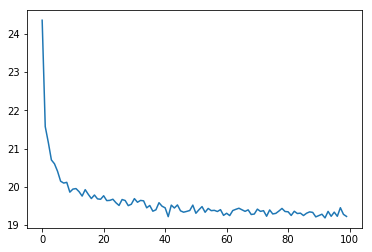

In [88]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [89]:
max_length = 20

def generate_one(category, start_char='A', temperature=0.5):
    category_input = make_category_input(category)
    chars_input = make_chars_input(start_char)
    hidden = rnn.init_hidden()
    
    output_str = start_char
    
    for i in range(max_length):
        output, hidden =  rnn(category_input, chars_input[0], hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        if top_i == EOS:
            break
        else:
            char = all_letters[top_i]
            output_str += char
            chars_input = make_chars_input(char)
            
    return output_str

def generate(category, start_chars='ABC'):
    for start_char in  start_chars:
        print(generate_one(category,start_char))

In [90]:
generate('names\\Russian', 'RUS')

Ryertev
Uronov
Stipovek


In [111]:
generate('names\\Turkish', 'ABC')

Aare
Basch
Caula
